# Efficient Nets
Using tensorflow

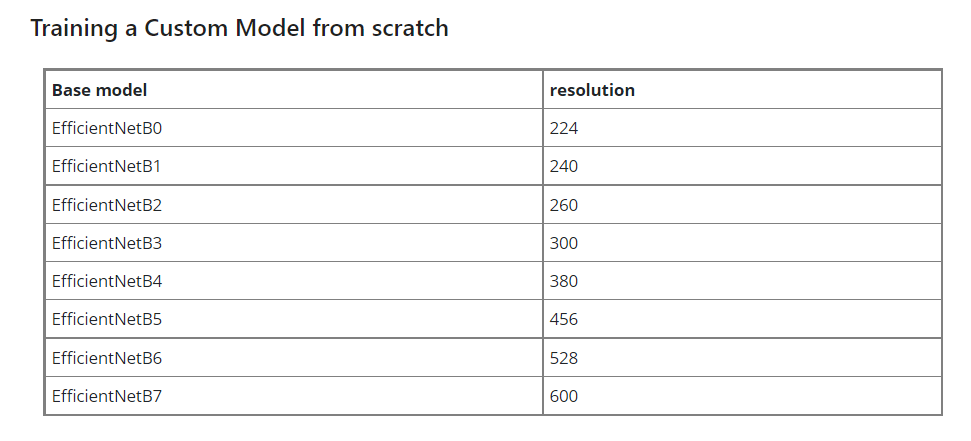

In [355]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB7
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import cv2

In [191]:
from pathlib import Path
import os
import seaborn as sns
from typing import Iterator, List, Union, Tuple
from datetime import datetime
from sklearn.model_selection import train_test_split

In [194]:
# !conda list scikit-learn

In [210]:
# print(tf.__version__)
# print(tf.keras.__version__)

## Load data

In [279]:
df1 = np.load('../ProcessedHistograms/Malawi/Malawi_2002.npy')

In [280]:
type(df1)

numpy.ndarray

In [281]:
df1.shape

(576, 46)

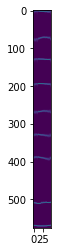

In [282]:
imshow(df1)

In [290]:
hist3d = df1.reshape(64,46,-1, order='F')
hist3d.shape

(64, 46, 9)

In [283]:
data = df1.reshape(-1,1)
data.shape
# imshow(data)

(26496, 1)

In [284]:
df2 = cv2.resize(df1, (600, 600))

In [285]:
df2.shape

(600, 600)

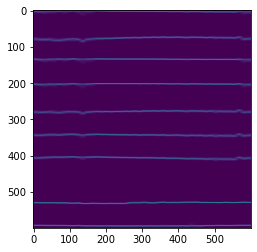

In [286]:
imshow(df2)

In [320]:
# req_country = 'Malawi'
def data_extraction(req_country): 
    processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/ProcessedHistograms')
    country_list = sorted(processed_path.glob('*'))
    train_x, train_y, test_x, test_y, val_x, val_y = [], [], [], [], [], []
    data_array = []
    df_label = get_label_data()   
    for country in country_list:
        if req_country in str(country):
            break
        
    data_list = sorted(country.glob('*.npy'))
    country_nme = str(country).split('\\')[-1]
    country_label = df_label.loc[country_nme]
    for i in data_list:
        year = str(i).split('_')[-1][:4]
        data_array = np.load(str(i.absolute()))
        data_array = cv2.resize(data_array, (224, 224))
        hist_3 = np.zeros((224,224, 3))
        hist_3[:,:,0] = data_array 
        hist_3[:,:,1] = data_array
        hist_3[:,:,2] = data_array
        if year < '2014':
            train_x.append(hist_3)
            train_y.append(country_label[year])
        elif year < '2015':
            val_x.append(hist_3)
            val_y.append(country_label[year])
        else:
            test_x.append(hist_3)
            test_y.append(country_label[year])

    return train_x, train_y, test_x, test_y, val_x, val_y


def get_label_data() -> pd.DataFrame:
    label_path = str(Path(os.getcwd()).parent.absolute()) + '/Yield_Data/yield.csv'
    df = pd.read_csv(label_path)
    df = df.set_index(['Country Name'])
    df = df.drop(['Country Code','Indicator Name', 'Indicator Code', '2019','2020', '2021'], axis=1)
    return df

In [203]:
# data = np.transpose(data_array)

In [204]:
# data.shape

In [205]:
# country, x_train, y_train = data_extraction("Malawi")
# len(train_x) # years

In [206]:
# len(train_x[0])

In [207]:
# x_train = np.array(train_x)
# x_train.shape

In [208]:
# x_train1 = x_train.reshape(14,-1)

In [209]:
# x_train1.shape

In [321]:
x_train,y_train,x_test,y_test, x_val, y_val = data_extraction('Malawi')

In [350]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)


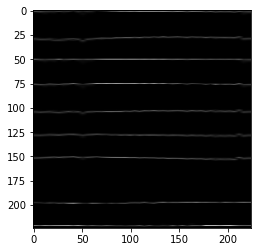

In [278]:
imshow(x_train[0])

In [357]:

    
def get_mean_baseline(y_train, y_test):
    df_train = pd.DataFrame(y_train, columns=['yield'])
    df_val = pd.DataFrame(y_test, columns=['yield'])
    y_hat = df_train['yield'].mean()
    df_val['y_hat']=y_hat
    mae = MeanAbsoluteError()
    mae = mae(df_val["yield"], df_val["y_hat"]).numpy()  
    mape = MeanAbsolutePercentageError()
    mape = mape(df_val["yield"], df_val["y_hat"]).numpy()
    print('Mean Absolute Error: ', mae)
    print("mean baseline MAPE: ", mape)
    return mape

def create_generators(x_train,y_train,x_test,y_test, x_val, y_val):
    train_generator = ImageDataGenerator() 
    
    validation_generator = ImageDataGenerator()     
    test_generator = ImageDataGenerator()
    
    train_generator = train_generator.flow(
        x_train,
        y_train,
        batch_size=2, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow(
        x_val,
        y_val,
        batch_size=1,
    )
    test_generator = test_generator.flow(
        x_test,
        y_test,
        batch_size=1,
    )
    return train_generator, validation_generator, test_generator
    

In [335]:
import multiprocessing
# no of cores
multiprocessing.cpu_count()

12

In [371]:
def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator,
    test_generator: Iterator,
) -> History:
    
    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()
    plot_model(model, to_file=model_name + ".jpg", show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=10, # adjust this according to the number of CPU cores of your machine
    )

    model.evaluate(
        test_generator,
        callbacks=callbacks,
    )
    return history

In [368]:
def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
    tensorboard_callback = TensorBoard(log_dir=logdir)
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=0.1,  # model should improve by at least 1%
        patience=50,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/" + model_name + ".h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]

In [363]:
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [375]:
def adapt_efficient_net() -> Model:
   
    inputs = layers.Input(shape=(224, 224, 3))  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)
#     # Freeze the pretrained weights
#     model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model

In [376]:
def plot_results(model_history_small_cnn: History, model_history_eff_net: History, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_small_cnn : History
        keras History object of the model.fit() method.
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict1 = {
        "MAPE": model_history_small_cnn.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "small_cnn",
    }
    dict2 = {
        "MAPE": model_history_small_cnn.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "small_cnn",
    }
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

Mean Absolute Error:  564.3583374023438
mean baseline MAPE:  25.443323135375977
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 173056)            0         
________________________________________

Epoch 26/100
6/6 [==============================] - 2s 255ms/step - loss: 482.3033 - mean_absolute_error: 482.3033 - mean_absolute_percentage_error: 36.4221 - val_loss: 588.6152 - val_mean_absolute_error: 588.6152 - val_mean_absolute_percentage_error: 26.5369
Epoch 27/100
6/6 [==============================] - 2s 256ms/step - loss: 484.9457 - mean_absolute_error: 484.9457 - mean_absolute_percentage_error: 36.8853 - val_loss: 583.8340 - val_mean_absolute_error: 583.8340 - val_mean_absolute_percentage_error: 26.3214
Epoch 28/100
6/6 [==============================] - 2s 258ms/step - loss: 488.1684 - mean_absolute_error: 488.1684 - mean_absolute_percentage_error: 35.4354 - val_loss: 641.2120 - val_mean_absolute_error: 641.2120 - val_mean_absolute_percentage_error: 28.9082
Epoch 29/100
6/6 [==============================] - 2s 259ms/step - loss: 494.3932 - mean_absolute_error: 494.3932 - mean_absolute_percentage_error: 34.6561 - val_loss: 655.6948 - val_mean_absolute_error: 655.6948 - val_

6/6 [==============================] - 2s 257ms/step - loss: 471.5275 - mean_absolute_error: 471.5275 - mean_absolute_percentage_error: 35.5837 - val_loss: 574.2854 - val_mean_absolute_error: 574.2854 - val_mean_absolute_percentage_error: 25.8909
Epoch 58/100
6/6 [==============================] - 2s 256ms/step - loss: 492.9474 - mean_absolute_error: 492.9474 - mean_absolute_percentage_error: 38.3559 - val_loss: 530.1636 - val_mean_absolute_error: 530.1636 - val_mean_absolute_percentage_error: 23.9017
Epoch 59/100
6/6 [==============================] - 2s 254ms/step - loss: 487.3344 - mean_absolute_error: 487.3344 - mean_absolute_percentage_error: 38.1058 - val_loss: 504.0243 - val_mean_absolute_error: 504.0243 - val_mean_absolute_percentage_error: 22.7232
Epoch 60/100
6/6 [==============================] - 2s 256ms/step - loss: 474.7533 - mean_absolute_error: 474.7533 - mean_absolute_percentage_error: 36.6135 - val_loss: 544.6833 - val_mean_absolute_error: 544.6833 - val_mean_absolute

C:\Users\talha\anaconda3\envs\pyhdf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


6/6 [==============================] - 107s 9s/step - loss: 1653.6670 - mean_absolute_error: 1653.6670 - mean_absolute_percentage_error: 99.9757 - val_loss: 2217.5361 - val_mean_absolute_error: 2217.5361 - val_mean_absolute_percentage_error: 99.9746
Epoch 2/100
6/6 [==============================] - 4s 676ms/step - loss: 1652.5352 - mean_absolute_error: 1652.5352 - mean_absolute_percentage_error: 99.8943 - val_loss: 2217.3054 - val_mean_absolute_error: 2217.3054 - val_mean_absolute_percentage_error: 99.9642
Epoch 3/100
6/6 [==============================] - 4s 776ms/step - loss: 1653.0687 - mean_absolute_error: 1653.0687 - mean_absolute_percentage_error: 99.9545 - val_loss: 2216.9692 - val_mean_absolute_error: 2216.9692 - val_mean_absolute_percentage_error: 99.9490
Epoch 4/100
6/6 [==============================] - 4s 668ms/step - loss: 1651.5785 - mean_absolute_error: 1651.5785 - mean_absolute_percentage_error: 99.8387 - val_loss: 2216.3679 - val_mean_absolute_error: 2216.3679 - val_m

6/6 [==============================] - 4s 739ms/step - loss: 575.0308 - mean_absolute_error: 575.0308 - mean_absolute_percentage_error: 31.8502 - val_loss: 839.3280 - val_mean_absolute_error: 839.3280 - val_mean_absolute_percentage_error: 37.8400
Epoch 33/100
6/6 [==============================] - 4s 670ms/step - loss: 548.5310 - mean_absolute_error: 548.5310 - mean_absolute_percentage_error: 30.7844 - val_loss: 625.1388 - val_mean_absolute_error: 625.1388 - val_mean_absolute_percentage_error: 28.1835
Epoch 34/100
6/6 [==============================] - 4s 762ms/step - loss: 503.7248 - mean_absolute_error: 503.7248 - mean_absolute_percentage_error: 29.2866 - val_loss: 487.7565 - val_mean_absolute_error: 487.7565 - val_mean_absolute_percentage_error: 21.9898
Epoch 35/100
6/6 [==============================] - 5s 877ms/step - loss: 488.6345 - mean_absolute_error: 488.6345 - mean_absolute_percentage_error: 31.7733 - val_loss: 452.2295 - val_mean_absolute_error: 452.2295 - val_mean_absolute

Epoch 62/100
6/6 [==============================] - 4s 719ms/step - loss: 475.3147 - mean_absolute_error: 475.3147 - mean_absolute_percentage_error: 35.1890 - val_loss: 84395.7344 - val_mean_absolute_error: 84395.7344 - val_mean_absolute_percentage_error: 3804.8660
Epoch 63/100
6/6 [==============================] - 4s 704ms/step - loss: 487.8396 - mean_absolute_error: 487.8396 - mean_absolute_percentage_error: 38.6093 - val_loss: 24251.9570 - val_mean_absolute_error: 24251.9570 - val_mean_absolute_percentage_error: 1093.3662
Epoch 64/100
6/6 [==============================] - 4s 746ms/step - loss: 485.0504 - mean_absolute_error: 485.0504 - mean_absolute_percentage_error: 38.3756 - val_loss: 2353.7217 - val_mean_absolute_error: 2353.7217 - val_mean_absolute_percentage_error: 106.1143
Epoch 65/100
6/6 [==============================] - 4s 728ms/step - loss: 479.3347 - mean_absolute_error: 479.3347 - mean_absolute_percentage_error: 36.7940 - val_loss: 2658.5522 - val_mean_absolute_error:

Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
1/1 [==============================] - 0s 91ms/step - loss: 376.6023 - mean_absolute_error: 376.6023 - mean_absolute_percentage_error: 23.6767


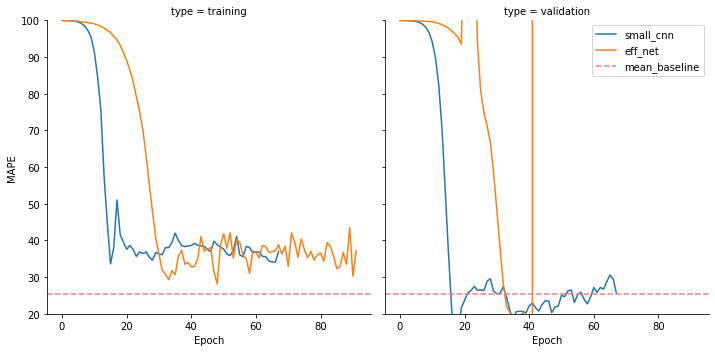

In [377]:
# def run(y_train, y_val):
mean_baseline = get_mean_baseline(y_train, y_val)
train_generator, validation_generator, test_generator = create_generators(x_train,y_train,x_test,y_test, x_val, y_val)
small_cnn_history = run_model(
    model_name="small_cnn",
    model_function=small_cnn(),
    lr=0.001,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)
eff_net_history = run_model(
    model_name="eff_net",
    model_function=adapt_efficient_net(),
    lr=0.05,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)
plot_results(small_cnn_history, eff_net_history, mean_baseline)

# with augmentation

In [352]:
def create_generators(x_train,y_train,x_test,y_test, x_val, y_val):
    train_generator = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2,
    ) 
    
    validation_generator = ImageDataGenerator()     
    test_generator = ImageDataGenerator()
    
    train_generator = train_generator.flow(
        x_train,
        y_train,
        batch_size=2, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow(
        x_val,
        y_val,
        batch_size=1,
    )
    test_generator = test_generator.flow(
        x_test,
        y_test,
        batch_size=1,
    )
    return train_generator, validation_generator, test_generator

mean_baseline = get_mean_baseline(y_train, y_val)
train_generator, validation_generator, test_generator = create_generators(x_train,y_train,x_test,y_test, x_val, y_val)
small_cnn_history = run_model(
    model_name="small_cnn",
    model_function=small_cnn(),
    lr=0.001,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [353]:
eff_net_history = run_model(
    model_name="eff_net",
    model_function=adapt_efficient_net(),
    lr=0.5,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)


Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
_______________________________________________________________________________________

C:\Users\talha\anaconda3\envs\pyhdf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
6/6 [==============================] - 102s 10s/step - loss: 1493.1040 - mean_absolute_error: 1493.1040 - mean_absolute_percentage_error: 90.3182 - val_loss: 22346082304.0000 - val_mean_absolute_error: 22346082304.0000 - val_mean_absolute_percentage_error: 1007442496.0000
Epoch 2/100
6/6 [==============================] - 3s 558ms/step - loss: 1493.6792 - mean_absolute_error: 1493.6792 - mean_absolute_percentage_error: 89.0975 - val_loss: 243118096384.0000 - val_mean_absolute_error: 243118096384.0000 - val_mean_absolute_percentage_error: 10960645120.0000
Epoch 3/100
6/6 [==============================] - 3s 441ms/step - loss: 1427.7891 - mean_absolute_error: 1427.7891 - mean_absolute_percentage_error: 84.2193 - val_loss: 107517018112.0000 - val_mean_absolute_error: 107517018112.0000 - val_mean_absolute_percentage_error: 4847257088.0000
Epoch 4/100
6/6 [==============================] - 3s 517ms/step - loss: 1335.9448 - mean_absolute_error: 1335.9448 - mean_absolute_percenta

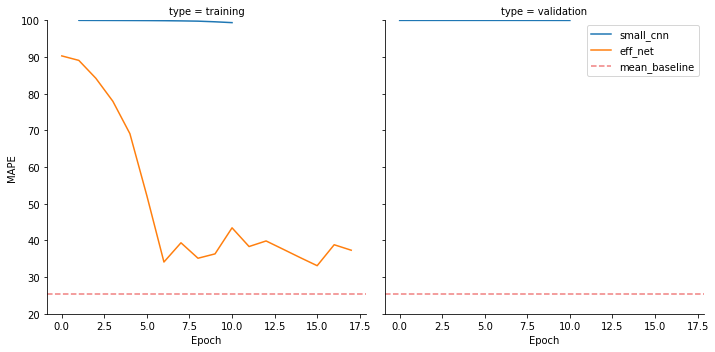

In [356]:
plot_results(small_cnn_history, eff_net_history, mean_baseline)

In [330]:
# to do: see efficient net in pytorch, 
# try testing with the resized image 224by224 (1)
# there should be a function to print out all acceptable inputs for efficient net, try that (2)
# search: eff net only for images e.g, hxwx3?? (3: also revise CNNs using the links opened)
# how to tune eff net hyperparameters?
# how to load hist to efficient net? (4: see the previous codes for cnn to see what is done): they use a 3D histogram = bins*time*bands
# hist3d = data_array.reshape(64,9,-1, order='F')
# ** what if I also keep the name of the country as an input. one hot encode it. another feature - would it be helpful? 

## Efficient Net (version Obsolete)

In [287]:
NUM_CLASSES = 3
IMG_SIZE = 224

inputs = layers.Input(shape=(224, 224, 3))

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [ ]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

hist = model.fit(train_x, train_y, epochs=30, verbose=2)

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
img_path = 'unseen.jfif'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [ ]:
preds=model.predict(x)
preds     # probabilities for being in each of the 3 classes